In [4]:
# !kaggle datasets download -d grassknoted/asl-alphabet

# Classification de signe main en language américain

=> https://www.tensorflow.org/tutorials/images/transfer_learning


In [1]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.manifold import TSNE
import seaborn as sns

import json
import time

from tqdm import tqdm


print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.7.0


In [29]:
import glob

test = glob.glob(".\\asl-alphabet\\asl_alphabet_test\\asl_alphabet_test\\*")
train = glob.glob(".\\asl-alphabet\\asl_alphabet_train\\asl_alphabet_train\\*\\*.jpg")
# train = 
train = np.array(train)
np.random.shuffle(train)
train = train[:320]


In [31]:
len(train)/32
# 

10.0

In [30]:
SIZE = 200
BATCH = 32

def MakeSet(listPath, test=False):
    if test:
        y = [label.split("\\")[-1].split("_")[0] for label in listPath]
    else:
        y = [label.split("\\")[-2] for label in listPath]
    o = OrdinalEncoder()
    y = o.fit_transform(np.array(y).reshape((-1, 1)))
    y = y.reshape((-1)).astype(np.int8)
    x = listPath
    return x, y, o.categories_[0].tolist()


def read_image(path, label):
    img = tf.image.decode_jpeg(tf.io.read_file(path),  channels=3)
    img = tf.image.resize(img, (SIZE, SIZE))
    img = tf.cast(img, tf.int32)/255
    return img, label


def save_in_dir(model, name = "model_reg"):
    import os
    os.makedirs(name)
    model.save(name)


def generateDataset(x, y):
    x = tf.constant(x)
    y = tf.constant(y)
    df = tf.data.Dataset.from_tensor_slices((x, y))
    df = df.shuffle(buffer_size=len(x))
    df = df.map(read_image, num_parallel_calls=tf.data.AUTOTUNE).cache()
    df = df.prefetch(buffer_size=2).batch(BATCH, drop_remainder=True)
    return df

from sklearn.model_selection import train_test_split

x, y, label = MakeSet(train)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

trainset = generateDataset(X_train, y_train)
testset = generateDataset(X_test, y_test)



## Visualisation de mon set de donnée

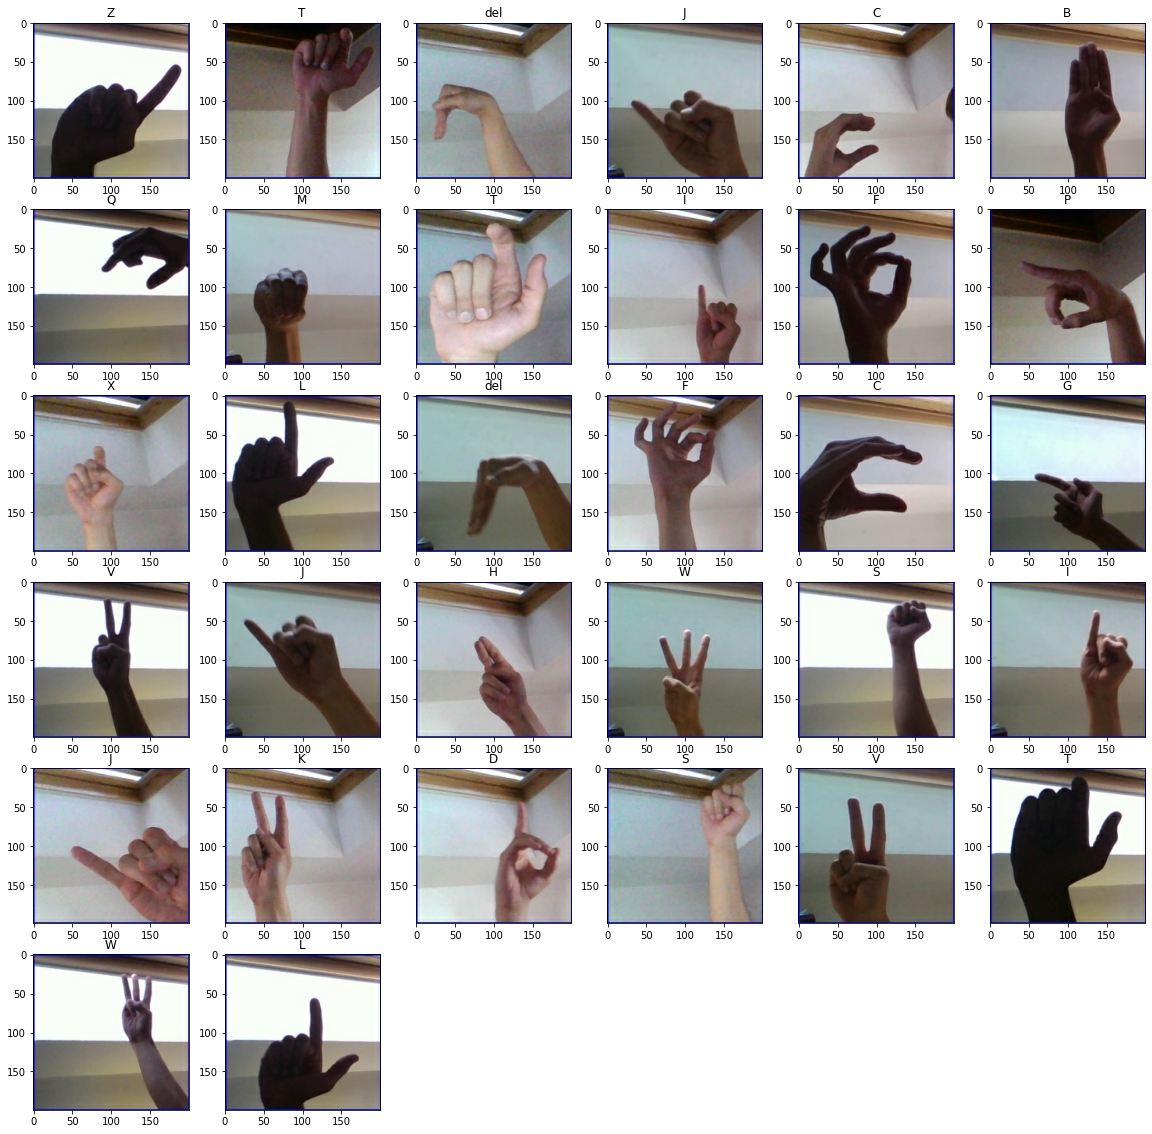

In [54]:
for batch in trainset.take(1):
    plt.figure(figsize=(20, 20))
    x, y = batch
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0]//5,x.shape[0]//5,i+1)
        plt.imshow(x[i])
        plt.title(label[y[i].numpy()])
        # plt.show()

## Commencement du NN:

In [6]:
def convolution(model, filters, name):
    model.add(layers.Conv2D(
      filters, (3, 3), strides=(1, 1), padding='same',
      activation="relu", name="conv"+name
    ))
    model.add(layers.Conv2D(
      filters, (3, 3), strides=(1, 1), padding='same',
      activation="relu", name="conv"+name+"_2"
    ))
    model.add(layers.MaxPooling2D(strides=(2,2), name="maxpool"+name))
    return model


def create_model(nn_out):
    model = keras.Sequential()
    model.add(keras.Input(shape=(200, 200, 3)))
    model = convolution(model, 32, "1")
    model = convolution(model, 64, "2")
    model = convolution(model, 128, "3")
    # model = convolution(model, 128, "4")
    model = convolution(model, 256, "5")
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(2048))
    model.add(layers.Dense(2048))
    model.add(layers.Dense(nn_out))
    return model

model = create_model(len(test)+1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 200, 200, 32)      896       
                                                                 
 conv1_2 (Conv2D)            (None, 200, 200, 32)      9248      
                                                                 
 maxpool1 (MaxPooling2D)     (None, 100, 100, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 100, 100, 64)      18496     
                                                                 
 conv2_2 (Conv2D)            (None, 100, 100, 64)      36928     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 50, 50, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 50, 50, 128)       7

## Réduire le temps d'entrainnement:
url: https://towardsdatascience.com/how-to-reduce-training-time-for-a-deep-learning-model-using-tf-data-43e1989d2961

Avoir tensorflow/GPU: https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tensorflow

In [159]:
from keras.callbacks import LearningRateScheduler

EPOCH = 1

def scheduler(epoch):
  if epoch < 10:
    return 10**(-4)
  else:
    return 10**(-5)

lr = LearningRateScheduler(scheduler)


model.compile(optimizer="Adam", 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])
history_a_aug = model.fit(trainset, epochs=EPOCH, 
                validation_data=testset, batch_size=BATCH*2, verbose=1,  callbacks=[lr])

2175/2175 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8740 - sparse_top_k_categorical_accuracy: 0.9436 

KeyboardInterrupt: 

## Résultat du modèle sur une Epoch

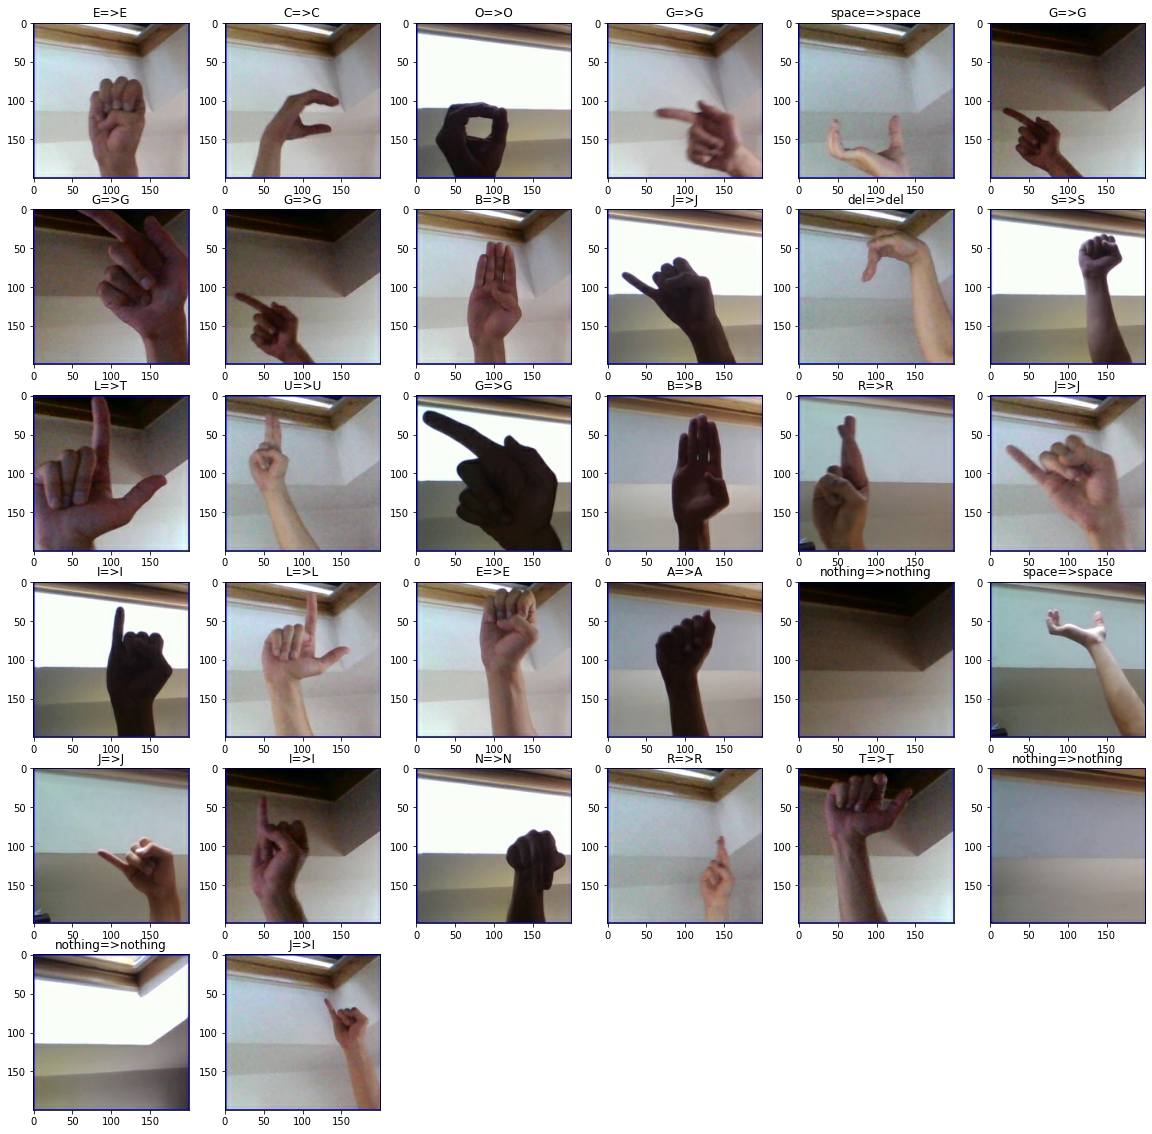

In [7]:
model = tf.keras.models.load_model('mon_model/my_model')

plt.figure(figsize=(20,20))
for batch in testset.take(1):
    x, y = batch
    pred = model.predict(x)
    pred = tf.argmax(pred, axis=1)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0]//5,x.shape[0]//5,i+1)
        plt.imshow(x[i])
        plt.title(label[y[i].numpy()] + "=>" + label[pred[i]] )

Il y a peu d'erreur mais le modèle semble surapprendre, exemple avec une photo de ma main en bas.

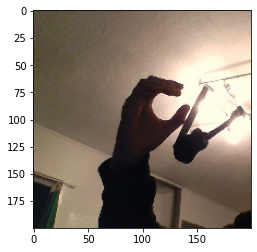

Label prédit: F alors que c'est C


In [8]:
img = tf.image.decode_jpeg(tf.io.read_file("MyTest.jpg"), channels=3)
img = tf.image.resize(img, (200, 200))
img = tf.cast(img, tf.int32)
plt.imshow(img)
plt.show()

img = img.numpy().reshape((1, 200, 200, 3))

pred = model.predict(img)
pred = tf.argmax(pred, axis=1)
print("Label prédit:", label[pred[0]], "alors que c'est C")

# Preprocessing d'image
#### https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/random_rotation

In [9]:
from tensorflow.keras.models import Model

model_tsne = Model(inputs=model.input, outputs=model.get_layer("global_max_pooling2d_8").output)
out = model_tsne(img)

In [10]:
def getVector(model, data):
    model, data = model_tsne, trainset
    preoprocessing = [
        lambda img: tf.image.random_contrast(img, 0.2, 0.5),
        lambda img: tf.image.random_brightness(img, 1),
        lambda img: tf.image.random_contrast(img, 0.1, 1),
        lambda img: tf.image.random_flip_up_down(img),
        lambda img: tf.image.random_flip_left_right(img),
        lambda img: tf.keras.preprocessing.image.random_zoom(img, (0.5, 1.5)), 
        lambda img: tf.keras.preprocessing.image.random_rotation(img, 20)
        ]

    lx = []
    ly = []
    for batch in data.take(4):
        x, y = batch
        for i in range(x.shape[0]):
            p = tf.stack([funct(x[i]) for funct in preoprocessing], axis=0)
            lx += [model.predict(p)]
            ly += [y[i]]*len(preoprocessing)
    return np.concatenate(lx), tf.stack(ly, axis=0)

x, y = getVector(model_tsne, trainset)

C:\Users\rmeut\anaconda3\envs\tradProj\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\rmeut\anaconda3\envs\tradProj\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 896 samples in 0.000s...
[t-SNE] Computed neighbors for 896 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 896 / 896
[t-SNE] Mean sigma: 2.463872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.736916
[t-SNE] KL divergence after 1000 iterations: 0.783241


C:\Users\rmeut\anaconda3\envs\tradProj\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

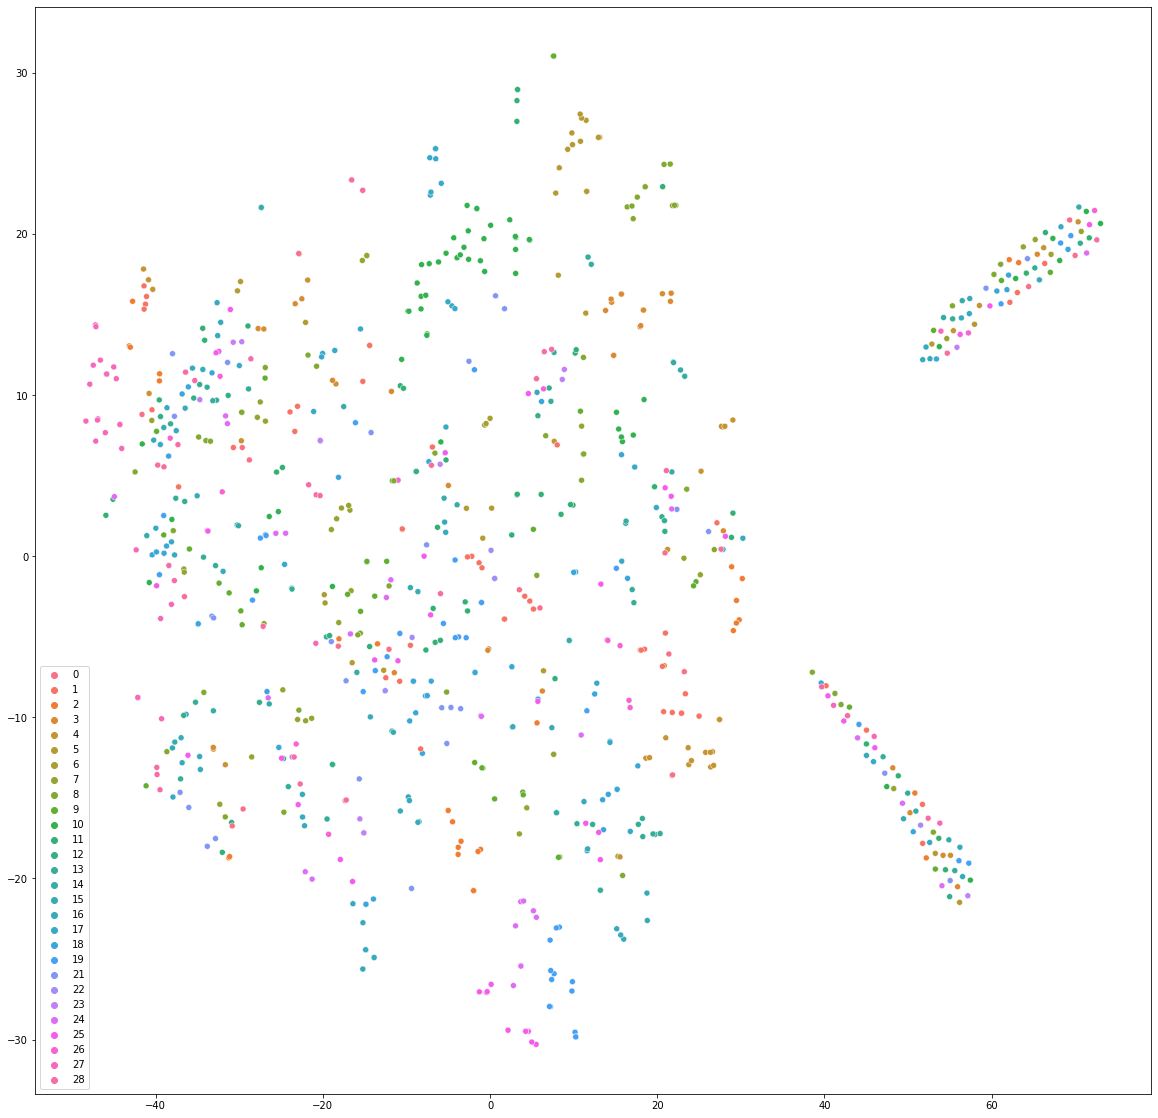

In [13]:
import seaborn as sns

ts = TSNE( n_components=2, verbose=1)
value = ts.fit_transform(x)
z = y.numpy()
c = sns.color_palette("husl", np.unique(z).shape[0])
plt.figure(figsize=(20, 20))
sns.scatterplot(value[:, 0], value[:, 1], hue=z, palette=c)


## Ajoute de filtre image pour la data augmentation

aiine
aiine
aiine
aiine
aiine
aiine
aiine
aiine
aiine
aiine


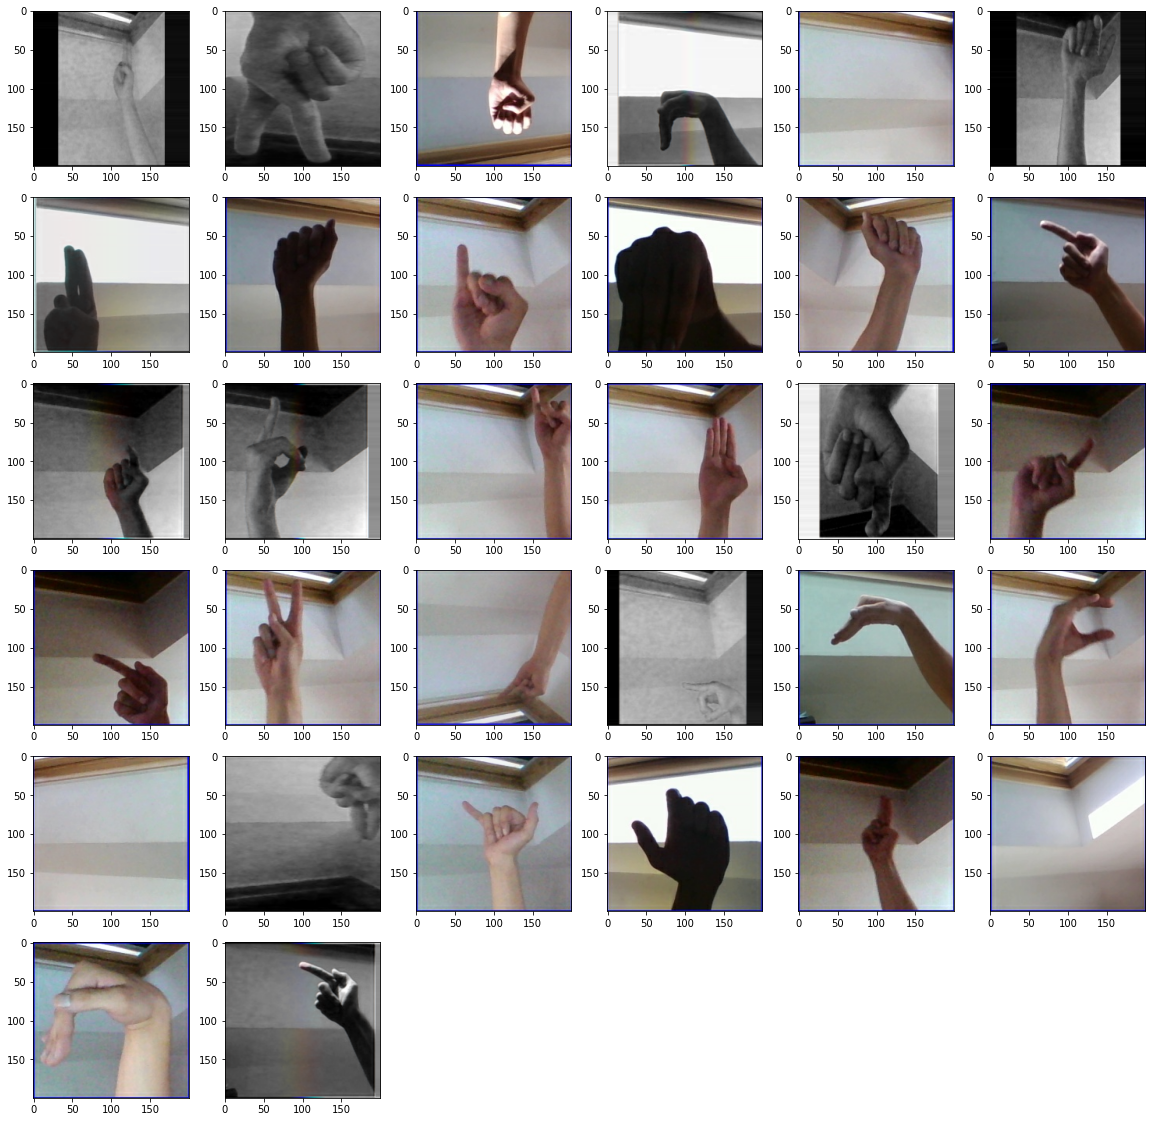

In [10]:
### Version prof !!

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_link,  batch_size=128,  shuffle=True, size=128, data_aug = False):
        self.batch_size = batch_size
        self.data = {}
        self.size=size
        self.auto_mode=False
        self.data_aug=data_aug
        chemin = data_link[0]
        labels = data_link[1]

        for i, ch in enumerate(chemin):
            img = tf.image.decode_jpeg(tf.io.read_file(ch), channels=3)
            self.data[i] = [(tf.cast(tf.image.resize(img, size=(size, size)),tf.int32)), labels[i]]
            if i % 1000 == 0:
                print("aiine")
        self.indices = list(self.data.keys())
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def aug(self, img):
        preoprocessing = [
            # lambda img: tf.image.random_brightness(img, 0.1),
            lambda img: tf.image.random_contrast(img, 0.8, 1),
            lambda img: tf.image.random_flip_up_down(img),
            lambda img: tf.image.random_flip_left_right(img),
            lambda img: tf.keras.preprocessing.image.random_zoom(img, (0.5, 1.5)), 
            lambda img: tf.keras.preprocessing.image.random_rotation(img, 10)
        ]
        preoprocessing = np.array(preoprocessing)

        choice = np.random.choice(10, preoprocessing.shape[0])
        if np.random.random()>=0.5:
            for prepro in preoprocessing[choice>5]:
                img = prepro(img)
        return img

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        keys = [self.indices[k] for k in index]
        return self.__get_data(keys)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, keys):

        size_=(self.size,self.size)
        X = np.empty((self.batch_size, size_[0], size_[1], 3))
        y =  np.empty((self.batch_size))
        for i, id in enumerate(keys):
            X[i,], y[i]  = self.aug(self.data[id][0]), self.data[id][1]

        if self.auto_mode:
          return X, X
        else:
          return X, y

x, y, label = MakeSet(train)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.01)
testset = DataGenerator((X_test, y_test), batch_size=32,  shuffle=True, size=200, data_aug = True)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.1)
trainset = DataGenerator((X_test, y_test), batch_size=32,  shuffle=True, size=200, data_aug = True)

plt.figure(figsize=(20,20))
x, y = trainset[0]
pred = model.predict(x)
pred = tf.argmax(pred, axis=1)
for i in range(x.shape[0]):
    plt.subplot(x.shape[0]//5,x.shape[0]//5,i+1)
    plt.imshow(tf.cast(x[i], tf.int32))


In [9]:
def read_image(path, label):
    preoprocessing = [
        # lambda img: tf.image.random_brightness(img, 0.1),
        lambda img: tf.image.random_contrast(img, 0.8, 1),
        lambda img: tf.image.random_flip_up_down(img),
        lambda img: tf.image.random_flip_left_right(img),
        lambda img: tf.keras.preprocessing.image.random_zoom(img, (0.5, 1.5)), 
        lambda img: tf.keras.preprocessing.image.random_rotation(img, 10)
    ]
    preoprocessing = np.array(preoprocessing)

    img = tf.image.decode_jpeg(tf.io.read_file(path),  channels=3)
    img = tf.image.resize(img, (200, 200))
    img = tf.keras.preprocessing.image.random_rotation(img, 10)
    # choice = np.random.choice(10, preoprocessing.shape[0])
    # if np.random.random()>=0.5:
    #     for prepro in preoprocessing[choice>5]:
    #         img = prepro(img)
    
    img = tf.cast(img, tf.int32)
    return img, label

def generateDataset(x, y):
    x = tf.constant(x)
    y = tf.constant(y)
    df = tf.data.Dataset.from_tensor_slices((x, y))
    df = df.shuffle(buffer_size=len(x))
    df = df.map(read_image, num_parallel_calls=tf.data.AUTOTUNE).cache()
    df = df.prefetch(buffer_size=2).batch(BATCH, drop_remainder=True)
    return df

x, y, label = MakeSet(train)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

trainset = generateDataset(X_train, y_train)
testset = generateDataset(X_test, y_test)


plt.figure(figsize=(20,20))
for batch in trainset.take(1):
    x, y = batch
    pred = model.predict(x)
    pred = tf.argmax(pred, axis=1)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0]//5,x.shape[0]//5,i+1)
        plt.imshow(tf.cast(x[i], tf.int32))


AttributeError: in user code:

    File "C:\Users\rmeut\AppData\Local\Temp/ipykernel_7296/1752426809.py", line 14, in read_image  *
        img = tf.keras.preprocessing.image.random_rotation(img, 10)
    File "C:\Users\rmeut\anaconda3\envs\tradProj\lib\site-packages\keras_preprocessing\image\affine_transformations.py", line 56, in random_rotation  *
        x = apply_affine_transform(x, theta=theta, channel_axis=channel_axis,
    File "C:\Users\rmeut\anaconda3\envs\tradProj\lib\site-packages\keras_preprocessing\image\affine_transformations.py", line 323, in apply_affine_transform  *
        x = np.rollaxis(x, channel_axis, 0)
    File "<__array_function__ internals>", line 5, in rollaxis  **
        
    File "C:\Users\rmeut\anaconda3\envs\tradProj\lib\site-packages\numpy\core\numeric.py", line 1317, in rollaxis
        n = a.ndim

    AttributeError: 'Tensor' object has no attribute 'ndim'


In [78]:
from keras.callbacks import LearningRateScheduler

EPOCH = 1

def scheduler(epoch):
  if epoch < 10:
    return 10**(-4)
  else:
    return 10**(-5)

lr = LearningRateScheduler(scheduler)


model.compile(optimizer="Adam", 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])
history_a_aug = model.fit(trainset, epochs=EPOCH, 
                validation_data=testset, batch_size=BATCH, verbose=1,  callbacks=[lr])

271/271 [==============================] - 1219s 4s/step - loss: 0.5658 - accuracy: 0.8426 - sparse_top_k_categorical_accuracy: 0.9483 - val_loss: 0.5968 - val_accuracy: 0.8449 - val_sparse_top_k_categorical_accuracy: 0.9387 - lr: 1.0000e-04


In [76]:
history_a_aug.history

{'loss': [0.8020506501197815],
 'accuracy': [0.8026983141899109],
 'sparse_top_k_categorical_accuracy': [0.9116697311401367],
 'val_loss': [0.5944182872772217],
 'val_accuracy': [0.8414351940155029],
 'val_sparse_top_k_categorical_accuracy': [0.9421296119689941],
 'lr': [1e-04]}

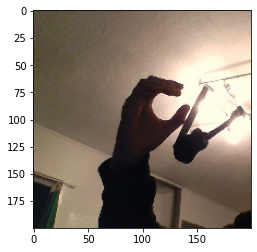

Label prédit: tf.Tensor(1, shape=(), dtype=int8)


In [21]:
img = tf.image.decode_jpeg(tf.io.read_file("MyTest.jpg"), channels=3)
img = tf.image.resize(img, (200, 200))
img = tf.cast(img, tf.int32)
plt.imshow(img)
plt.show()

img = img.numpy().reshape((1, 200, 200, 3))

pred = model.predict(img)
pred = tf.argmax(pred, axis=1)
label
print("Label prédit:", label)#[pred[0]], "alors que c'est C")


## Comprendre le modèle avec grad cam

In [24]:
# model.save('./mymodel_2')

def grad_cam(model, img):
    from  scipy import ndimage
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("conv5_2").output, model.output]
    )
    # grad_model.summary()
    with tf.GradientTape()   as tape:
        convlayer, pred = grad_model(img[None, :])
        p = tf.argmax(pred[0])
        actif = pred[:, p]
    print(p)
    grad = tape.gradient(actif, convlayer)

    pool_grad = tf.reduce_mean(grad, axis=(0, 1, 2)) # Pour chaque pixel on prend la moyenne donc il reste la moyenne des filtres

    print(convlayer.shape, pool_grad.shape)

    heatmap = np.dot(convlayer, pool_grad)
    heatmap = np.squeeze(heatmap)
    heatmap[heatmap<0] = 0
    zoom_factor =  int(img.shape[0]/heatmap.shape[0])
    zoo_heat = ndimage.zoom(heatmap, zoom_factor)
    zoo_heat = (zoo_heat - np.min(zoo_heat))/(np.max(zoo_heat)-np.min(zoo_heat))
    return zoo_heat, img 


In [155]:
# model = tf.keras.models.load_model('mon_model/my_model')

tf.Tensor(12, shape=(), dtype=int8)
tf.Tensor(1, shape=(), dtype=int64)
(1, 25, 25, 256) (256,)


C:\Users\rmeut\AppData\Local\Temp/ipykernel_13484/216458267.py:18: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1, orientation='horizontal')


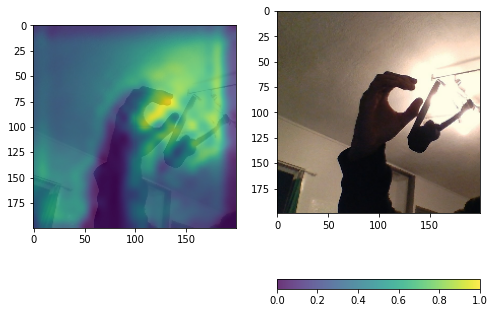

In [25]:
def plot_hm_on_image(cam,img,cam_w = 0.3):

  my_cmap = plt.cm.OrRd(np.arange(plt.cm.OrRd.N))

  # Set alpha
  my_cmap[:,-1] = np.linspace(0, 1 , plt.cm.OrRd.N)

  # Create new colormap
  
  f, axarr = plt.subplots(1,2)
  f.set_figheight(8)
  f.set_figwidth(8)
  axarr[0].imshow(img)
  im1 = axarr[0].imshow(cam, interpolation='nearest', alpha = cam_w)
  axarr[1].imshow(img)
  

  plt.colorbar(im1, orientation='horizontal')
# i = trainset[45]

# k= 21
# img, label = i[0][k], i[1][k]

print(label)

grad, pic = grad_cam(model, img)

plot_hm_on_image(grad,tf.cast(pic, tf.int32),cam_w = 0.8)


## Normalisation du CNN:
Ici le modèle semble overfitter car le donné sont dans un contexte précis le but étant d'éviter ce problème en appliquant une régularisation 

Use case: https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7


In [5]:
from tensorflow.keras import regularizers

def convolution(model, filters, name):
    model.add(layers.Conv2D(
      filters, (3, 3), strides=(1, 1), padding='same',
      activation="relu", name="conv"+name
    ))
    model.add(layers.BatchNormalization(name="batch"+name)) # Ajout de batchnorm
    model.add(layers.Conv2D(
      filters, (3, 3), strides=(1, 1), padding='same',
      activation="relu", name="conv"+name+"_2",
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ))
    model.add(layers.MaxPooling2D(strides=(2,2), name="Pool_"+name))
    return model


def create_model(nn_out):
    model = keras.Sequential()
    model.add(keras.Input(shape=(200, 200, 3)))
    model = convolution(model, 32, "1")
    model = convolution(model, 64, "2")
    model = convolution(model, 128, "3")
    # model.add(layers.Dropout(0.5))
    model = convolution(model, 256, "5")
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(2048))
    model.add(layers.Dense(2048))
    model.add(layers.Dense(nn_out))
    return model

model = create_model(len(test)+1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 200, 200, 32)      896       
                                                                 
 batch1 (BatchNormalization)  (None, 200, 200, 32)     128       
                                                                 
 conv1_2 (Conv2D)            (None, 200, 200, 32)      9248      
                                                                 
 Pool_1 (MaxPooling2D)       (None, 100, 100, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 100, 100, 64)      18496     
                                                                 
 batch2 (BatchNormalization)  (None, 100, 100, 64)     256       
                                                                 
 conv2_2 (Conv2D)            (None, 100, 100, 64)      3

In [38]:
from keras.callbacks import LearningRateScheduler, Callback

class BCP(keras.callbacks.Callback):
    batch_accuracy = [] # accuracy at given batch
    batch_sparse_top_k_categorical_accuracy = [] # loss at given batch    
    batch_loss = [] # loss at given batch
    batch_val_accuracy = [] # accuracy at given batch
    batch_val_sparse_top_k_categorical_accuracy = [] # loss at given batch    
    batch_val_loss = [] # loss at given batch    
        
    def __init__(self):
        super(BCP,self).__init__() 

    def on_train_batch_end(self, batch, logs=None):                
        BCP.batch_accuracy.append(logs.get('accuracy'))
        BCP.batch_sparse_top_k_categorical_accuracy.append(logs.get('sparse_top_k_categorical_accuracy'))
        BCP.batch_loss.append(logs.get('loss'))
        ## Impossible d'avoir car la val est calculé en fin d'époque
        
    def on_epoch_end(self, epoch, logs=None):
        BCP.batch_val_accuracy.append(logs.get('val_accuracy'))
        BCP.batch_val_sparse_top_k_categorical_accuracy.append(logs.get('val_sparse_top_k_categorical_accuracy'))
        BCP.batch_val_loss.append(logs.get('val_loss'))
        
        # print(logs)

    # def on_test_batch_end(self, batch, logs=None):
    #     print("second:",
    #         logs
    #     )



EPOCH = 2

def scheduler(epoch):
  if epoch < 10:
    return 10**(-4)
  else:
    return 10**(-5)

lr = LearningRateScheduler(scheduler)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
UserHistory = BCP()

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.compile(optimizer="Adam", 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])
history_epoch = model.fit(trainset, epochs=EPOCH,
                validation_data=testset, batch_size=BATCH, 
                verbose=1,  callbacks=[earlyStop, lr], 
                steps_per_epoch=5
                )#, workers=tf.data.AUTOTUNE, use_multiprocessing=True)

Epoch 1/2
5/5 [==============================] - 22s 4s/step - loss: 0.3855 - accuracy: 0.9563 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.3932 - val_accuracy: 0.1562 - val_sparse_top_k_categorical_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 2/2
5/5 [==============================] - 13s 2s/step - loss: 0.4599 - accuracy: 0.9375 - sparse_top_k_categorical_accuracy: 0.9896 - val_loss: 3.3898 - val_accuracy: 0.1406 - val_sparse_top_k_categorical_accuracy: 0.3906 - lr: 1.0000e-04


## Use tensorboard pour le kiff
https://neptune.ai/blog/tensorboard-tutorial

In [ ]:
# %load_ext tensorboard
# log_folder = 'logs'
# %tensorboard --logdir logs/fit


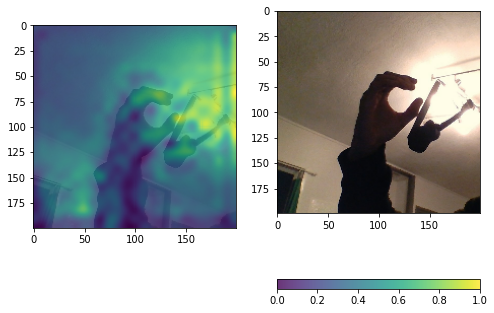

5/8 [=================>............] - ETA: 11s - loss: 0.2134 - accuracy: 1.0000 - sparse_top_k_categorical_accuracy: 1.0000

KeyboardInterrupt: 

In [34]:
from IPython.display import clear_output
%matplotlib inline


for i in range(100):
        history_epoch = model.fit(trainset, epochs=EPOCH, 
                        validation_data=testset, batch_size=BATCH, verbose=1,  callbacks=[earlyStop, lr, UserHistory])#, workers=tf.data.AUTOTUNE, use_multiprocessing=True)
        grad, pic = grad_cam(model, img)
        clear_output(wait=True)
        plot_hm_on_image(grad,tf.cast(pic, tf.int32),cam_w = 0.8)
        plt.show()
        

tf.Tensor(12, shape=(), dtype=int8)


NameError: name 'grad_cam' is not defined

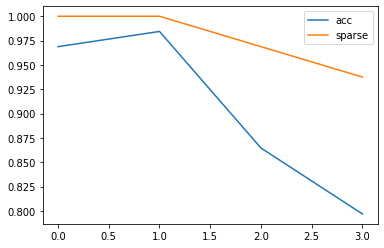

In [22]:
import pandas as pd
pd.Series(UserHistory.batch_accuracy).plot()
# pd.Series(UserHistory.batch_loss).plot()
# pd.Series(UserHistory.batch_val_loss).plot()
pd.Series(UserHistory.batch_sparse_top_k_categorical_accuracy).plot()
plt.legend(["acc",  "sparse"])
for i in trainset.take(2):
    k= 21
    img, label = i[0][k], i[1][k]
    print(label)
    grad, pic = grad_cam(model, img)
    plot_hm_on_image(grad,tf.cast(pic, tf.int32),cam_w = 0.8)

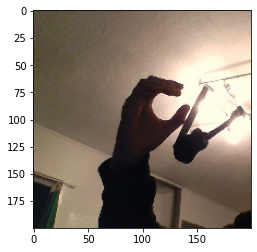

Label prédit: tf.Tensor(12, shape=(), dtype=int8)


NameError: name 'grad_cam' is not defined

In [23]:
img = tf.image.decode_jpeg(tf.io.read_file("MyTest.jpg"), channels=3)
img = tf.image.resize(img, (200, 200))
img = tf.cast(img, tf.int32)
plt.imshow(img)
plt.show()

img = img.numpy()

pred = model.predict(img.reshape((1, 200, 200, 3)))
pred = tf.argmax(pred, axis=1)
label
print("Label prédit:", label)#[pred[0]], "alors que c'est C")
grad, pic = grad_cam(model, img)
plot_hm_on_image(grad,tf.cast(pic, tf.int32),cam_w = 0.8)